In [331]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [332]:
import notebook
notebook.__version__

'6.4.10'

In [333]:
# Use seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [334]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


In [335]:
# Define columns to use
columns_to_use = ["global_x", "global_y", "v_class", "global_time"] #using just 4 of them

# Define chunk size for reading data
chunk_size = 100

# Initialize an empty list to store data chunks
data_chunks = []

for chunk in pd.read_csv("https://data.transportation.gov/resource/8ect-6jqj.csv", 
                         chunksize=chunk_size, usecols=columns_to_use):
    data_chunks.append(chunk)

# Concatenate data chunks into a single DataFrame
trajectory_dataset = pd.concat(data_chunks, ignore_index=True)

# trajectory_dataset = pd.read_csv(
#     "https://data.transportation.gov/resource/8ect-6jqj.csv")

#   names=["Vehicle_ID", "Frame_Id", "Total_Frames", "Global_Time", "Local_X",
#            "Local_Y", "Global_X", "Global_Y", "v_length", "v_Width", "v_Vel", 
#            "v_Acc", "Lane_ID", "O_Zone", "D_Zone", "Int_ID", "Section_ID", "Direction",
#            "Movement", "Preceding", "Following", "Space_Headway", "Time_Headway", "Location"]

In [336]:
global_x_counts = trajectory_dataset['global_x'].value_counts()

print(global_x_counts)

2230521.592    60
2230522.533    44
2230518.994    37
2230522.629    28
2230521.572    19
               ..
2230530.140     1
2230521.616     1
2230519.540     1
2230520.658     1
2230520.543     1
Name: global_x, Length: 689, dtype: int64


In [337]:
t_dataset = trajectory_dataset.copy()
t_dataset.tail()

,global_time,global_x,global_y,v_class
995,1163074800,2230522.629,1375574.155,2
996,1163074100,2230522.629,1375574.155,2
997,1163054800,2230522.629,1375574.155,2
998,1163054300,2230522.629,1375574.155,2
999,1163071000,2230522.629,1375574.155,2


In [338]:
t_dataset.isna().sum()

global_time    0
global_x       0
global_y       0
v_class        0
dtype: int64

In [339]:
train_dataset = t_dataset.sample(frac=0.80, random_state=0)
test_dataset = t_dataset.drop(train_dataset.index)

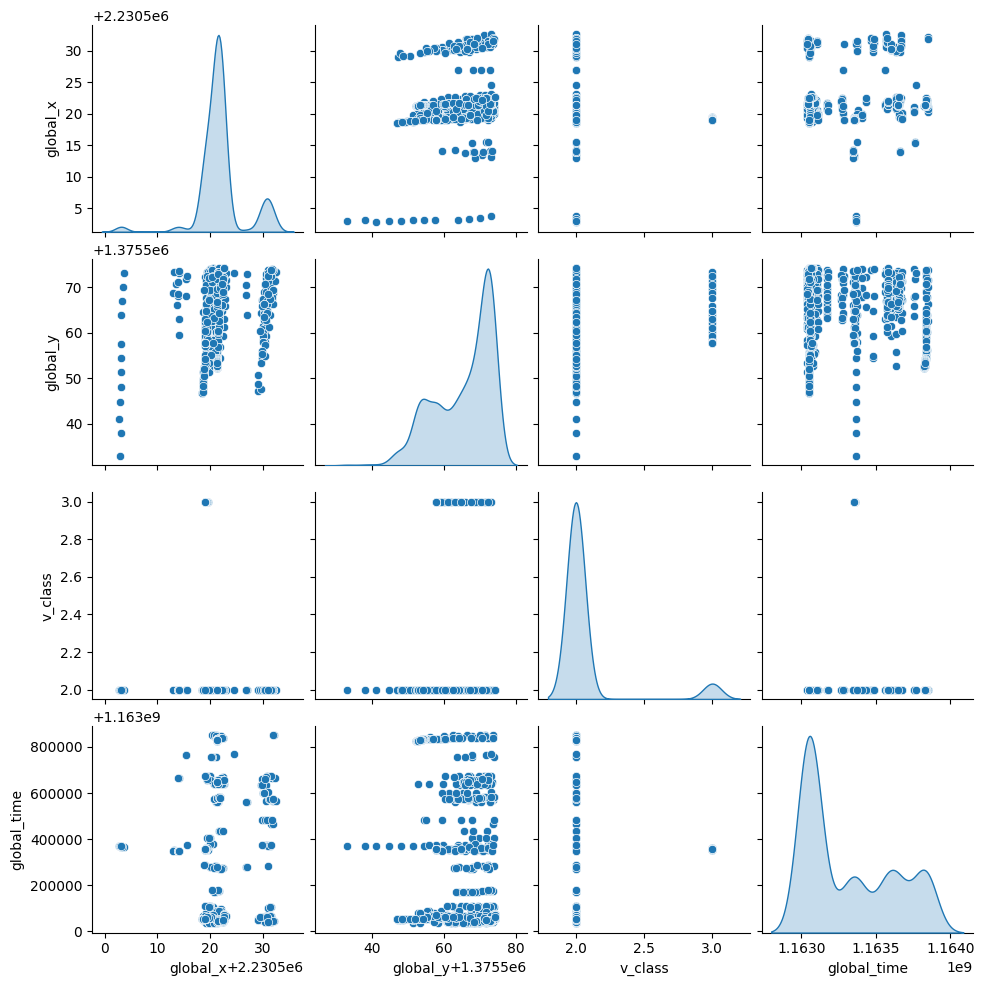

In [340]:
sns.pairplot(train_dataset[['global_x', 'global_y', 'v_class', 'global_time']], diag_kind='kde')

In [341]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
global_time,800.0,1.163318e+09,301508.798208,1.163035e+09,1.163050e+09,1.163171e+09,1.163582e+09,1.163850e+09
global_x,800.0,2.230522e+06,4.236260,2.230503e+06,2.230520e+06,2.230522e+06,2.230523e+06,2.230533e+06
global_y,800.0,1.375566e+06,7.937817,1.375533e+06,1.375558e+06,1.375568e+06,1.375572e+06,1.375574e+06
v_class,800.0,2.072500e+00,0.259476,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00


In [342]:
# Creating copies of the datasets
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_features.head() # checking the features

,global_time,global_x,global_y,v_class
993,1163063100,2230522.629,1375574.155,2
859,1163048200,2230521.592,1375573.194,2
298,1163039400,2230530.621,1375560.836,2
553,1163035000,2230519.957,1375569.755,2
672,1163048200,2230522.533,1375571.657,2


In [343]:
train_labels = train_features.pop('global_x')
test_labels = test_features.pop('global_x')
train_labels.head() # checking the labels

993    2230522.629
859    2230521.592
298    2230530.621
553    2230519.957
672    2230522.533
Name: global_x, dtype: float64

In [344]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [345]:
normalizer.adapt(np.array(train_features))

In [346]:
print(normalizer.mean.numpy())

[[1.163e+09 1.376e+06 2.072e+00]]


In [347]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[1.16e+09 1.38e+06 2.00e+00]]

Normalized: [[-0.85  1.1  -0.28]]


In [367]:
gtime = np.array(train_features['global_time'])
gtime_normalizer = layers.Normalization(input_shape=[1,], axis=None)
gtime_normalizer.adapt(gtime)

In [368]:
# Normalize the output labels (global_x), OPTIONAL
global_x = np.array(train_labels)
global_x_normalizer = layers.Normalization(axis=-1)
global_x_normalizer.adapt(global_x)

In [369]:
gtime_model = tf.keras.Sequential([
    gtime_normalizer,
    layers.Dense(units=1)
])

gtime_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_151 (Dense)           (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [370]:
gtime_model.predict(gtime[:10])

1/1 [==============================] - 0s 67ms/step


array([[ 1.292],
       [ 1.368],
       [ 1.412],
       [ 1.434],
       [ 1.368],
       [ 1.226],
       [ 1.345],
       [-0.197],
       [ 1.277],
       [ 0.737]], dtype=float32)

In [371]:
gtime_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [372]:
%%time
history = gtime_model.fit(
    train_features['global_time'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 6.28 s, sys: 2 s, total: 8.29 s
Wall time: 4.99 s


In [373]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2230330.75,2230330.0,95
96,2230328.75,2230328.0,96
97,2230327.00,2230326.0,97
98,2230324.75,2230324.0,98
99,2230322.75,2230322.0,99


In [374]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3000000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [global_x]')
  plt.legend()
  plt.grid(True)

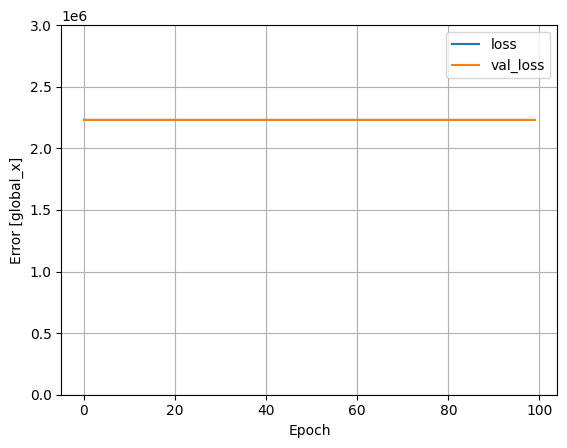

In [375]:
plot_loss(history)

In [376]:
test_results = {}

test_results['gtime_model'] = gtime_model.evaluate(
    test_features['global_time'],
    test_labels, verbose=0)

In [377]:
x = tf.linspace(0.0, 250, 251)
y = gtime_model.predict(x)

8/8 [==============================] - 0s 1ms/step


In [378]:
def plot_gtime(x, y):
  plt.scatter(train_features['global_time'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('global_time')
  plt.ylabel('global_x')
  plt.legend()

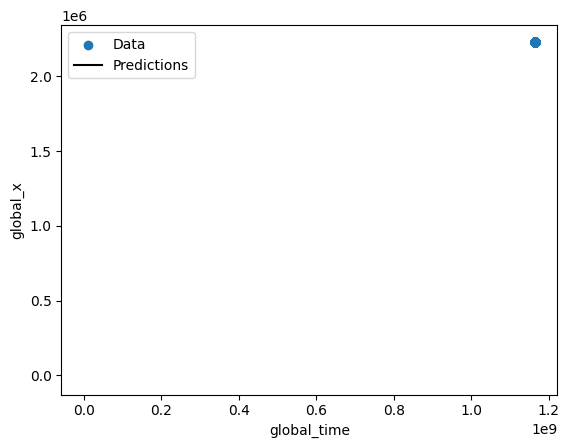

In [379]:
plot_gtime(x, y)

In [427]:
def build_and_compile_model(norm_input):
  model = keras.Sequential([
      norm_input,
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(64, activation='relu'),
      #norm_output,  # Add normalization layer for output labels
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [428]:
# dnn_gtime_model = build_and_compile_model(gtime_normalizer)
dnn_gtime_model = build_and_compile_model(gtime_normalizer)
dnn_gtime_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_214 (Dense)           (None, 32)                64        
                                                                 
 dense_215 (Dense)           (None, 32)                1056      
                                                                 
 dense_216 (Dense)           (None, 32)                1056      
                                                                 
 dense_217 (Dense)           (None, 32)                1056      
                                                                 
 dense_218 (Dense)           (None, 32)                1056      
                                                     

In [413]:
# # Checking the shape of the input and output
# print("Shape of train_features:", train_features.shape)
# print("Shape of train_labels:", train_labels.shape)

# print("Input shape of gtime_normalizer:", gtime_normalizer.input_shape)
# print("Input shape of global_x_normalizer:", global_x_normalizer.input_shape)

In [429]:
%%time
history = dnn_gtime_model.fit(
    train_features['global_time'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 18 s, sys: 2.89 s, total: 20.9 s
Wall time: 11.9 s


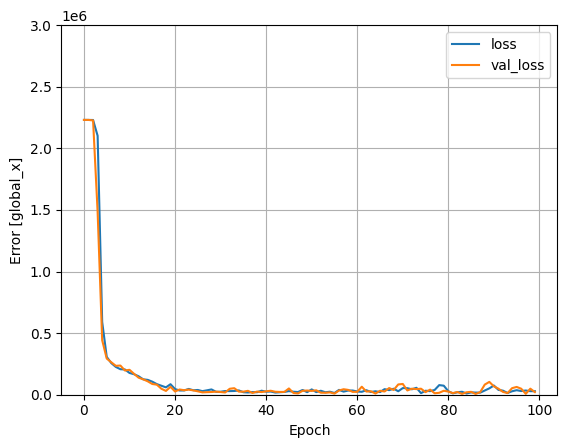

In [430]:
plot_loss(history)

In [283]:
# # Generate a sequence of global_time values for prediction
# x_values = tf.linspace(0.0, 250, 100)

# # Reshape the input data to match the model's input shape
# x_values_reshaped = tf.reshape(x_values, (-1, 1))

# # Predict the corresponding global_x values using the trained model
# predicted_global_x_values = dnn_gtime_model.predict(x_values_reshaped)

# # Plot the predicted global_x values against the input global_time values
# plt.plot(x_values, predicted_global_x_values, label='Predicted global_x')
# plt.xlabel('global_time')
# plt.ylabel('global_x')
# plt.title('Predicted global_x vs global_time')
# plt.legend()
# plt.show()

In [431]:
x = tf.linspace(0.0, 250, 100)
y = dnn_gtime_model.predict(x)

4/4 [==============================] - 0s 2ms/step


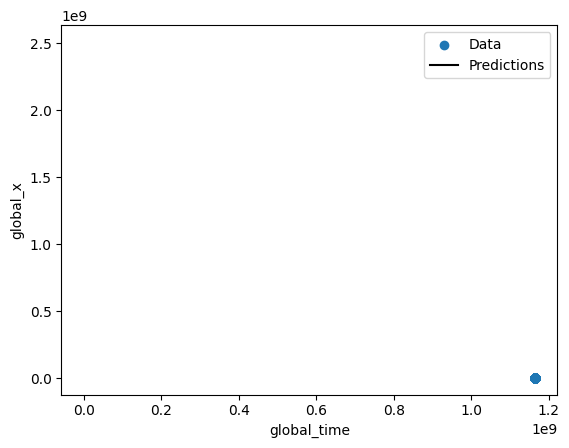

In [432]:
plot_gtime(x, y)

In [433]:
test_results['dnn_gtime_model'] = dnn_gtime_model.evaluate(
    test_features['global_time'], test_labels,
    verbose=0)

In [434]:
row_199 = trajectory_dataset.iloc[995]

# Print out the complete row information
print(row_199)

global_time    1.163075e+09
global_x       2.230523e+06
global_y       1.375574e+06
v_class        2.000000e+00
Name: 995, dtype: float64


In [435]:
# Select a single test sample from the test dataset
sample_index = 199  # Index of the sample you want to evaluate
test_sample_global_time = test_features['global_time'].iloc[sample_index]
actual_global_x = test_labels.iloc[sample_index]

# Reshape the test sample to match the model's input shape
test_sample_global_time_reshaped = np.array([[test_sample_global_time]])

# Use the model to make a prediction for the test sample
predicted_global_x = dnn_gtime_model.predict(test_sample_global_time_reshaped)[0][0]

# Compare the predicted and actual values
print("Actual global_x:", actual_global_x)
print("Predicted global_x:", predicted_global_x)

1/1 [==============================] - 0s 157ms/step
Actual global_x: 2230522.629
Predicted global_x: 2240723.5


In [227]:
# dnn_gtime_model.predict(gtime[:10])

In [230]:
# test_predictions = dnn_gtime_model.predict(test_features).flatten()

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values [global_x]')
# plt.ylabel('Predictions [global_x]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [436]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliz  (None, 3)                 7         
 ation)                                                          
                                                                 
 dense_234 (Dense)           (None, 32)                128       
                                                                 
 dense_235 (Dense)           (None, 32)                1056      
                                                                 
 dense_236 (Dense)           (None, 32)                1056      
                                                                 
 dense_237 (Dense)           (None, 32)                1056      
                                                                 
 dense_238 (Dense)           (None, 32)                1056      
                                                     

In [437]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 16.4 s, sys: 2.55 s, total: 18.9 s
Wall time: 10.4 s


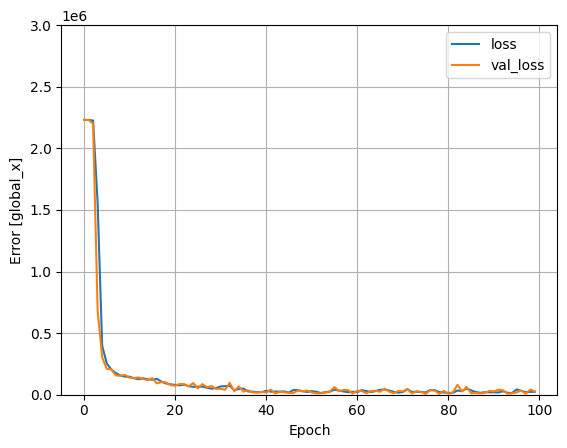

In [438]:
plot_loss(history)

In [439]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [440]:
pd.DataFrame(test_results, index=['Mean absolute error [global_x]']).T

,Mean absolute error [global_x]
gtime_model,2.230322e+06
dnn_gtime_model,2.239087e+04
dnn_model,2.510161e+04


7/7 [==============================] - 0s 2ms/step


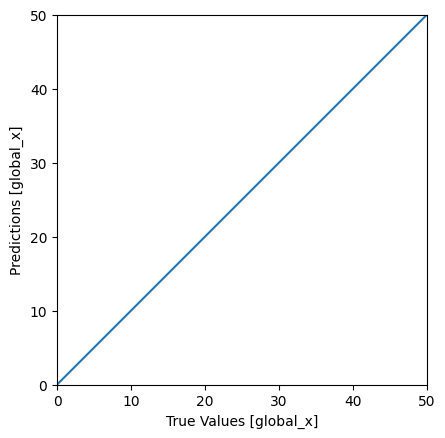

In [441]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [global_x]')
plt.ylabel('Predictions [global_x]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)